## Business Question:
`Business Goal:` Identify the categories of emergencies that are most prevalent in medical questions. This information is relevant because the majority of healthcare costs come from patients admitted in emergency rooms. Identifying the most common reasons for these emergencies would help implement targeted prevention measures to reduce these emergencies, while also reducing healthcare costs imposed on the healthcare system.

`Technical Proposal:` Using the text in the **emergencymedicine**, **AskDocs**, and **medicine** subreddits, we will be able to examine causes for medical concern. This can be accomplished by applying regex and creating Boolean variables. In order to find the relevant diagnoses, we will join the subreddit data with external data that provides a list of emergency room diagnoses (this data can be found in *data/csv/emergency_room_diagnoses_2021.csv*). New Boolean variables can then be added to determine which of these diagnoses can be identified in the subreddits, thus identifying if the concern usually ends up in the ER. We can also use sentiment analysis to determine relative severity of these diagnoses and compare. Additionally, by performing NLP and examining common words we can gain insight into important context around these concerns.

In [0]:
## IMPORTING ALL THE LIBRARIES
import os
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col, isnan, when, count, regexp_extract, split, col, lower, regexp_replace
import pyspark.sql.functions as f
from pyspark.sql.types import ArrayType, DoubleType
import re
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF
from pyspark.ml import Pipeline
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import StringType, MapType
from pyspark.sql import Window

In [0]:
## Setting up file directories to save small data and associated plots
CSV_DIR = "../../data/csv"
PLOT_DIR = "../../data/plots"

In [0]:
ems_sub = spark.read.parquet("/FileStore/ems_subs2")
ems_com = spark.read.parquet("/FileStore/ems_coms2")

In [0]:
ems_sub.printSchema()

root
 |-- adserver_click_url: string (nullable = true)
 |-- adserver_imp_pixel: string (nullable = true)
 |-- archived: boolean (nullable = true)
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_id: string (nullable = true)
 |-- brand_safe: boolean (nullable = true)
 |-- contest_mode: boolean (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- crosspost_parent: string (nullable = true)
 |-- crosspost_parent_list: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- approved_at_utc: string (nullable = true)
 |    |    |-- approved_by: string (nullable = true)
 |    |    |-- archived: boolean (nullable = true)
 |    |    |-- author: string (nullable = true)
 |    |    |-- author_flair_css_class: string (nullable = true)
 |    |    |-- author_flair_text: string (nullable = true)
 |    |    |-- b

In [0]:
ems_com.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)



In [0]:
print(ems_sub.count())

472453


In [0]:
print(ems_com.count())

1709216


### Reading in External Emergency Room Diagnoses

In [0]:
diagnoses = spark.read.parquet("/FileStore/erd_2021").toPandas()

In [0]:
diagnoses.head()

,ICDCMCode,DiagnosisDesc,TotalDiag
0,M66.269,"SPONTANEOUS RUPTURE OF EXTENSOR TENDONS, UNSP ...",1
1,T70.4XXA,"EFFECTS OF HIGH-PRESSURE FLUIDS, INITIAL ENCOU...",29
2,M66.271,"SPONTANEOUS RUPTURE OF EXTENSOR TENDONS, RIGHT...",1
3,T70.4XXD,"EFFECTS OF HIGH-PRESSURE FLUIDS, SUBSEQUENT EN...",1
4,M66.28,"SPONTANEOUS RUPTURE OF EXTENSOR TENDONS, OTHER...",3


In [0]:
top_diagnoses = diagnoses.groupby('DiagnosisDesc').sum('TotalDiag').sort_values(by = ['TotalDiag'], ascending = False).head(75)

In [0]:
# ------------------------------------------------------------------------------------------------------------------------------------ #
#
# REDEFINE NAMES FOR THE DIAGNOSES TO FIT REDDIT DISCOURSE
#
# ------------------------------------------------------------------------------------------------------------------------------------ #

new_diags = ['digestive tract', 'upper respiratory infection', 'allergy to narcotic', 'allergy to antibiotic', 'allergy to drugs', 'allergy to penicillin', 'anemia', 'anxiety', 'atherosclerosis', 'coronary artery heart disease', 'chest pain', 'chronic obstructive pulmonary disease', 'constipation', 'exposure to COVID-19', 'cough', 'COVID-19', 'dehydration', 'diarrhea', 'dizziness', 'immunization', 'stomach pain', 'hypertension', 'fever', 'gastro-esophageal reflux disease', 'headache', 'heart failure', 'homelessness', 'hyperlipidemia', 'hypothyroidism', 'anticoagulants', 'aspirin', 'insulin', 'hypoglycemic', 'lower back pain', 'depression', 'nausea', 'nausea with vomiting', 'addiction to nicotine', 'addiction', 'obesity', 'other chest pain', 'other chronic pain', 'drug therapy', 'postprocedural', 'nicotine dependence', 'transient ischemic attack', 'hypercholesterolemia', 'shortness of breath', 'collapse', 'tachycardia', 'type 2 diabetes with chronic kidney disease', 'type 2 diabetes', 'abdominal pain', 'uncomplicated asthma', 'atrial fibrillation', 'head injury', 'urinary tract infection', 'unspecified vomiting', 'weakness']


In [0]:
# ------------------------------------------------------------------------------------------------------------------------------------ #
# 
# IDENTIFY IF ANY WORDS IN THE TEXT ARE IN THE LIST OF DIAGNOSES
#
# ------------------------------------------------------------------------------------------------------------------------------------ #
diagnoses_str = "(?i)" + "|(?i)".join(new_diags)
ems_sub_df = ems_com.withColumn('diagnosed', when(col('body').rlike(diagnoses_str), True))

In [0]:
# ------------------------------------------------------------------------------------------------------------------------------------ #
#
# IF SO, THEN ADD THE MATCHED WORD TO A COLUMN CALLED "EMS_TOPIC" 
#
# ------------------------------------------------------------------------------------------------------------------------------------ #
ems_labeled = ems_sub_df.withColumn('ems_topic', regexp_extract(col('body'), diagnoses_str, 0))
ems_labeled.show()

+--------------+--------------+----------------------+--------------------+--------------------+--------+----------------+-----------+-------------+-------------+------+-------+------------+---------+----------+--------------------+------------+-----+--------+---------+------------+---------+---------+
|        author|author_cakeday|author_flair_css_class|   author_flair_text|                body|can_gild|controversiality|created_utc|distinguished|       edited|gilded|     id|is_submitter|  link_id| parent_id|           permalink|retrieved_on|score|stickied|subreddit|subreddit_id|diagnosed|ems_topic|
+--------------+--------------+----------------------+--------------------+--------------------+--------+----------------+-----------+-------------+-------------+------+-------+------------+---------+----------+--------------------+------------+-----+--------+---------+------------+---------+---------+
|       Paula92|          null|                  null|Phlebotomy studen...|I have never 

In [0]:
# ------------------------------------------------------------------------------------------------------------------------------------ #
# 
# ADD DUMMY FOR FATAL OR NOT
# 
# ------------------------------------------------------------------------------------------------------------------------------------ #
death_diags = ['death', 'died', 'die', 'fatal', 'fatality', 'deceased', 'mortality', 'mortal', 'dying', 'passed away', 'passing away', 'killed', 'lost his life', 'lost her life', 'loss of life', 'flatline', 'pulled the plug']

death_str = "(?i)" + "|(?i)".join(death_diags)
ems_labeled = ems_labeled.withColumn('fatal', when(col('body').rlike(death_str), True))

ems_labeled.show()

+--------------+--------------+----------------------+--------------------+--------------------+--------+----------------+-----------+-------------+-------------+------+-------+------------+---------+----------+--------------------+------------+-----+--------+---------+------------+---------+---------+-----+
|        author|author_cakeday|author_flair_css_class|   author_flair_text|                body|can_gild|controversiality|created_utc|distinguished|       edited|gilded|     id|is_submitter|  link_id| parent_id|           permalink|retrieved_on|score|stickied|subreddit|subreddit_id|diagnosed|ems_topic|fatal|
+--------------+--------------+----------------------+--------------------+--------------------+--------+----------------+-----------+-------------+-------------+------+-------+------------+---------+----------+--------------------+------------+-----+--------+---------+------------+---------+---------+-----+
|       Paula92|          null|                  null|Phlebotomy stude

#### Table 1

In [0]:
## Displaying a table of counts of comments that mention ER diagnoses and those that do not
diagnosed_count = ems_labeled.groupBy(col('diagnosed')).count().toPandas()
diagnosed_count

,diagnosed,count
0,None,1634389
1,True,74827


This table shows the number of comments we found mentioning an ER diagnosis vs. not mentioning one. Out of 1.7 million comments across the 3 subreddits, around 74,000 mentioned some form of common ER diagnosis.

In [0]:
diagnosed_count.to_csv(os.path.join(CSV_DIR,"diagnosis_mentions_count.csv"))

In [0]:
all_topics = ems_labeled.where(col('ems_topic') != "")
all_topics.show()

+-------------------+--------------+----------------------+--------------------+--------------------+--------+----------------+-----------+-------------+-------------+------+-------+------------+---------+----------+--------------------+------------+-----+--------+---------+------------+---------+------------+-----+
|             author|author_cakeday|author_flair_css_class|   author_flair_text|                body|can_gild|controversiality|created_utc|distinguished|       edited|gilded|     id|is_submitter|  link_id| parent_id|           permalink|retrieved_on|score|stickied|subreddit|subreddit_id|diagnosed|   ems_topic|fatal|
+-------------------+--------------+----------------------+--------------------+--------------------+--------+----------------+-----------+-------------+-------------+------+-------+------------+---------+----------+--------------------+------------+-----+--------+---------+------------+---------+------------+-----+
|            Paula92|          null|          

In [0]:
# all_topics.write.parquet('/FileStore/Medical_topics_data')

#### Skip to here to read in Merged Data

In [0]:
topics_labeled = spark.read.parquet('/FileStore/Medical_topics_data')
topics_labeled = topics_labeled.withColumn('ems_topic', f.lower(col('ems_topic')))

### Building Sentiment Model

In [0]:
# ------------------------------------------------------------------------------------------------------------------------------------ #
#
# CLEAN BODY OF DATA
#
# ------------------------------------------------------------------------------------------------------------------------------------ #
# Clean the text of unnecessary characters and such
def clean_text(c):
  c = lower(c)
  c = regexp_replace(c, "(https?\://)\S+", "") # Remove links
  c = regexp_replace(c, "(\\n)|\n|\r|\t", "") # Remove CR, tab, and LR
  c = regexp_replace(c, "(?:(?:[0-9]{2}[:\/,]){2}[0-9]{2,4})", "") # Remove dates
  c = regexp_replace(c, "@([A-Za-z0-9_]+)", "") # Remove usernames
  c = regexp_replace(c, "[0-9]", "") # Remove numbers
  c = regexp_replace(c, "\:|\/|\#|\.|\?|\!|\&|\"|\,", "") # Remove symbols
  return c
df = topics_labeled.withColumn("body", clean_text(col("body"))) # Clean the body column

# Document assembler to prep the body of the reddit posts
document = DocumentAssembler()\
    .setInputCol("body")\
    .setOutputCol("document")

# Sentence Detector
sentence = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

# Tokenizer
token = Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

# Stop words
stop_words = StopWordsCleaner.pretrained('stopwords_en', 'en')\
    .setInputCols(["token"]) \
    .setOutputCol("cleanTokens") \
    .setCaseSensitive(False)

tokenAssembler = TokenAssembler() \
    .setInputCols(["sentence", "cleanTokens"]) \
    .setOutputCol("cleanText")

use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["cleanText"])\
 .setOutputCol("sentence_embeddings")


sentimentdl = SentimentDLModel.pretrained(name='sentimentdl_use_twitter', lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

prediction_pipeline = Pipeline(
    stages = [
        document,
        sentence,
        token,
        stop_words,
        tokenAssembler,
        use,
        sentimentdl
    ]
)

result = prediction_pipeline.fit(df).transform(df)


stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]


In [0]:
sentiment_df = result.select('body', 'retrieved_on','subreddit','ems_topic',f.explode('sentiment.result'))
sentiment_df.show(5)

+--------------------+------------+---------+----------+--------+
|                body|retrieved_on|subreddit| ems_topic|     col|
+--------------------+------------+---------+----------+--------+
|my dad used a jac...|        null| medicine|depression|negative|
|oh yeahi sort of ...|        null|  AskDocs|     cough|negative|
|nadtimeline sound...|        null|  AskDocs|depression|positive|
|i have never than...|  1655560144| medicine|  diarrhea|negative|
|possibly or diffe...|  1655560116| medicine|     cough|negative|
+--------------------+------------+---------+----------+--------+
only showing top 5 rows



In [0]:
## Writing to dbfs
#sentiment_df.write.parquet("/FileStore/sentiment_ems")

### Skip to here to read in Sentiment Data

In [0]:
sentiment_df = spark.read.parquet('/FileStore/sentiment_ems')
sentiment_df = sentiment_df.withColumnRenamed("col","sentiment")

#### Summary Graph of Counts of Each Diagnosis

In [0]:
# ------------------------------------------------------------------------------------------------------------------------------------ #
#
# CREATE SUMMARY TABLE OF COUNTS OF EACH DIAGNOSIS
#
# ------------------------------------------------------------------------------------------------------------------------------------ #
# This answers part of the question "What are the most common words overall?".
ems_com_summary = sentiment_df.groupby('ems_topic').count().toPandas()
ems_com_summary['ems_topic'] = ems_com_summary['ems_topic'].str.upper()

ems_com_summary_sorted = ems_com_summary.sort_values(by = ['count'], ascending = False).reset_index().drop(columns = ['index'])
ems_com_summary_sorted

,ems_topic,count
0,ANXIETY,20420
1,FEVER,8554
2,HEADACHE,6890
3,COVID-19,6529
4,DEPRESSION,5915
5,COUGH,4584
6,CHEST PAIN,3481
7,NAUSEA,3207
8,INSULIN,2872
9,OBESITY,2801


##### Graph 1

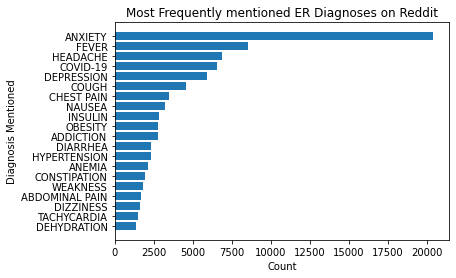

In [0]:
## Creating plot of top 20 diagnoses
top_20_diagnosis = ems_com_summary_sorted.head(20).sort_values(by = ['count'])
plt.barh(y = 'ems_topic', width = 'count', data = top_20_diagnosis)
plt.xlabel("Count")
plt.ylabel("Diagnosis Mentioned")
plt.title("Most Frequently mentioned ER Diagnoses on Reddit")
plt.savefig(os.path.join(PLOT_DIR, "top_20_diagnosis.jpg"))
plt.show()

The plot (Plot 1) above illustrates the counts of common emergency room diagnoses that were the subject of Emergency Medicine, AskDocs, and medicine subreddits. Based on the data, the most prevalent reason for serious medical discussion is anxiety, with 17,416 mentions. Fever is a relatively close second, while the rest of the mentions surprisingly have to do with general health and not acute events. Thus, the table above confirms that the majority of hospital visits are actually a result of bad health, as opposed to disastrous events.

In [0]:
## Saving the csv
top_20_diagnosis.to_csv(os.path.join(CSV_DIR, "top_20_diagnosis.csv"))

### What is the distribution of text lengths?

In [0]:
# ------------------------------------------------------------------------------------------------------------------------------------ #
#
# What is the distribution of text lengths? (of the posts with diagnosis key words, how long is each post)
#
# ------------------------------------------------------------------------------------------------------------------------------------ #

length_df = sentiment_df.withColumn("length", f.length(col('body')))


#### Table 2

In [0]:
length_summary = length_df.agg(  
                            f.mean(col('length')).alias('mean'),
                            f.expr("percentile(length, array(0.25))")[0].alias('Q25'),
                            f.expr('percentile(length, array(0.50))')[0].alias('median'),
                            f.expr('percentile(length, array(0.75))')[0].alias('Q75')).toPandas().rename(index = {0:"length"})
length_summary

,mean,Q25,median,Q75
length,746.644364,224.0,437.0,860.0


In [0]:
length_summary.to_csv(os.path.join(CSV_DIR, "ER_com_length_dist.csv"))

#### Graph 2

In [0]:
l = length_df.groupBy(col('ems_topic')).agg(f.mean('length').alias("mean_length")).toPandas()

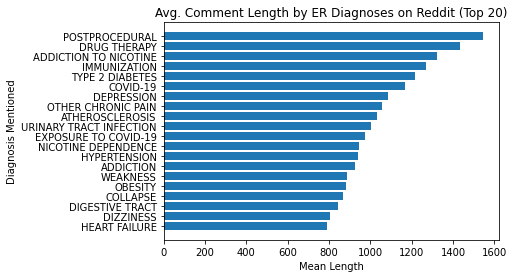

In [0]:
top_20_length = l.sort_values(by = ['mean_length'], ascending = False).head(20).sort_values(by = ['mean_length'])
y = top_20_length['ems_topic'].str.upper().tolist()
x = top_20_length['mean_length'].tolist()
plt.barh(y = y, width = x)
plt.xlabel("Mean Length")
plt.ylabel("Diagnosis Mentioned")
plt.title("Avg. Comment Length by ER Diagnoses on Reddit (Top 20)")
plt.savefig(os.path.join(PLOT_DIR, "top_20_diagnosis_length.jpg"))
plt.show()

In [0]:
top_20_length.to_csv(os.path.join(CSV_DIR, "top_20_diagnosis_length.csv"))

Graph 2 shows how a lot of the most known and serious issues generate the most thoughtful replies. Posprocedural is an interesting leader, but given the lack of common discussion around it and complications that ensue, it is an area that many people clearly have thoughts on. We also see drug related topics, Diabetes, and COVID-19 on this list indicating that people like to talk about common yet serious problems at length.

### Sentiment Model Analysis

#### Table 3

In [0]:
## Examining % of positive to negative comments
sentiment_dist = sentiment_df.groupBy('sentiment').count().toPandas()
sentiment_dist['percent'] = round(100 * sentiment_dist['count']/sentiment_dist['count'].sum(),2)
sentiment_dist = sentiment_dist[['sentiment','percent']]
sentiment_dist

,sentiment,percent
0,positive,26.62
1,neutral,2.09
2,negative,71.29


In [0]:
sentiment_dist.to_csv(os.path.join(CSV_DIR, "sentiment_dist.csv"))

The majority of the comments mentioning an ER diagnosis are negative which makes sense given the serious and often grave nature of a lot of these ailments. The positive comments are likely hopeful responses to people's concerns, which is nice to see.

#### Graph 3 - TF-IDF Graph

In [0]:
# Dev for TF-IDF

#REFERENCE: https://stackoverflow.com/questions/69218494/pyspark-display-top-10-words-of-document 

# Prep the documents to pass to the TF-IDF
# Used the cleaned, tokenized data that we created from the pipeline
documents = result.select("*").withColumn("label", monotonically_increasing_id())
documents = documents.select("label","cleanTokens.result")
#documents.show(2)

# #hashingTF way
hashingTF = HashingTF(inputCol="result", outputCol="rawFeatures")
featurizedData = hashingTF.transform(documents)
#featurizedData.show(5)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)
# rescaledData.show(truncate=False)
#print(hashingTF.indexOf("Possibly"))


## to read output vector and map to word, we use hash values of each word using same fitted model and map with features vector indices and get corresponding values.
ndf = documents.select('label',f.explode('result').name('expwords')).withColumn('result',f.array('expwords'))
#ndf.show(5) # cols: "label", "expwords", "words"
hashudf = f.udf(lambda vector : vector.indices.tolist()[0],StringType())
wordtf = hashingTF.transform(ndf).withColumn('wordhash',hashudf(f.col('rawFeatures')))
#wordtf.show()

## flatten output features column to get indices & value.
udf1 = f.udf(lambda vec : dict(zip(vec.indices.tolist(),vec.values.tolist())),MapType(StringType(),StringType()))
valuedf = rescaledData.select('label',f.explode(udf1(f.col('features'))).name('wordhash','value'))
#valuedf.show()

## get top n words for each document(label) filtering based on its rank and join both DFs and collect & sort to get the words along with its value.
w = Window.partitionBy('label').orderBy(f.desc('value'))
valuedf = valuedf.withColumn('rank',f.rank().over(w)).where(f.col('rank')<=5) # used 5 for testing.

topn_df = valuedf.join(wordtf,
                       ['label','wordhash']).groupby('label').agg(f.sort_array(f.collect_set(f.struct(f.col('value'),f.col('expwords'))),asc=False).name('topn')) #.show(truncate=False)

topn_df.printSchema()


root
 |-- label: long (nullable = false)
 |-- topn: array (nullable = false)
 |    |-- element: struct (containsNull = false)
 |    |    |-- value: string (nullable = true)
 |    |    |-- expwords: string (nullable = true)



In [0]:
#https://sparkbyexamples.com/pyspark/pyspark-select-nested-struct-columns/
words_and_vals = topn_df.select("topn.value", "topn.expwords") #.show(truncate = False)
words_and_vals.show()

+--------------------+--------------------+
|               value|            expwords|
+--------------------+--------------------+
|[8.51489722436658...|[advocated, self-...|
|[9.87017773061402...|[afraid, recreati...|
|[9.89637080845371...|[complex, epidemi...|
|[9.96549293552284...|[people, adults, ...|
|[9.43118795624074...|[takethe, pharmac...|
|[8.00407160060059...|[horrid, weights,...|
|[7.25265551191667...|[low-grade, varia...|
|[6.92155363666118...|[medicine, cough,...|
|[9.61350951303469...|[charger, high-co...|
|[9.92291148229550...|[supposed, remake...|
|[9.43118795624074...|[lithotripsy, bla...|
|[8.68718324201671...|[bleeding, red, b...|
|[9.61350951303469...|[“correct”, “out”...|
|[9.91404821812056...|[history, ruminat...|
|[7.3943060289797,...|[gfr, creatinine,...|
|[9.83665306434890...|[geralgine, list,...|
|[7.12860286324669...|[storm, joke, wea...|
|[9.43118795624074...|[delt, hit, myalg...|
|[8.92036233247474...|[biontech, arm, s...|
|[7.48527780718542...|[radiates,

In [0]:
from pyspark.sql.functions import explode

# GOAL: Try to explode each row so that each word is associated with a specific value and a label that connects the word & value to the corresponding row in  words_and_vals 
wv_labeled = words_and_vals.select("*").withColumn("row_label", monotonically_increasing_id()) # label the rows to identify when words come from different comments

In [0]:
wv_exploded_expwords = wv_labeled.select(wv_labeled.row_label, explode(wv_labeled.expwords)).withColumn("index", monotonically_increasing_id()).selectExpr("index", "row_label", "col as word")
wv_exploded_values = wv_labeled.select(wv_labeled.row_label, explode(wv_labeled.value)).withColumn("index", monotonically_increasing_id()).selectExpr("index", "row_label as row_label_1", "col as value")

wv_exploded = wv_exploded_expwords.join(wv_exploded_values, on = 'index')
wv_exploded_final = wv_exploded.selectExpr("index", "row_label", "word", "value")
wv_exploded_final.show(10)

+-----+---------+-----------+-----------------+
|index|row_label|       word|            value|
+-----+---------+-----------+-----------------+
|   26|        5|    weights| 6.94628130645274|
|   29|        5|      round|   6.018940738392|
|  474|       94|stimulation|6.745610610990589|
|  964|      193|   patients| 9.95483696480087|
| 1677|      337|  requisite|9.613509513034694|
| 1697|      341| moderately|7.048560155573158|
| 1806|      362|    sobbing|8.389734081412579|
| 1950|      391|   fixation|7.726439864002315|
| 2040|      409|      based|3.603223211686125|
| 2214|      446|        bit|9.591312243953675|
+-----+---------+-----------+-----------------+
only showing top 10 rows



In [0]:
from pyspark.sql.functions import sum,avg,count

# Now creating a graph for word importance  

# group by the word and take the average of the values if there are multiple
avg_count = wv_exploded_final.groupBy('word').agg(avg('value').alias('average'),
                                                   count('word').alias('count'))
avg_count.show(10)


+------------+------------------+-----+
|        word|           average|count|
+------------+------------------+-----+
|    uptodate| 7.095813040423706|   13|
|      freaks| 7.612029512824573|   26|
|    priority| 6.260102795208889|   20|
|       cramp| 7.639428487012683|   23|
|      marrow|6.7011588484197535|   14|
|       crest|  9.43118795624074|    2|
|accumulation| 8.514897224366585|    7|
|   hemolyzed| 9.277037276413482|    5|
|  fermenting|  9.43118795624074|    4|
|  electrical| 6.588218437239159|   21|
+------------+------------------+-----+
only showing top 10 rows



In [0]:

# convert to Pandas dataframe
avg_count_df = avg_count.toPandas() # convert to dataframe


In [0]:
# convert to csv
# avg_count_df.to_csv(os.path.join(CSV_DIR, "avg_count.csv"))

In [0]:
import numpy as np

# THIS MAY NOT GIVE AN ACCURATE REPRESENTATION OF THE DATA, IF IT'S CLEANED IN THIS WAY
# find the outliers and remove them

q1 = np.quantile(avg_count_df['average'], 0.25)
q3 = np.quantile(avg_count_df['average'], 0.75)

iqr = q3 - q1

lower = q1 - (1.5 * iqr)
upper = q3 + (1.5 * iqr)

remove_lower = avg_count_df[avg_count_df['average'] >= lower]
avg_count_df_cleaned = remove_lower[remove_lower['average'] <= upper]


avg_count_df_cleaned = avg_count_df_cleaned.reset_index(drop = True)
avg_count_df_cleaned

# convert to csv
avg_count_df_cleaned.to_csv(os.path.join(CSV_DIR, "avg_count_cleaned.csv"))

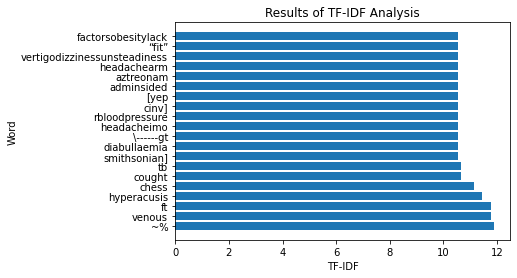

In [0]:
## top 20 words plotted
top_20_tfidf = avg_count_df_cleaned.sort_values('average', ascending = False)[:20]

plt.barh(y = "word", width = "average", data = top_20_tfidf)
plt.title("Results of TF-IDF Analysis")
plt.ylabel('Word')
plt.xlabel('TF-IDF')
plt.savefig(os.path.join(PLOT_DIR, "top_20_tfidf.jpg"))
plt.show()

## next idea: have the above graph without words overlayed (and a trend line instead) to visualize the relationship btwn the count and avg importance of all the words

#### Graph 4/5 - Most Positive and Most Negative ER Diagnoses

In [0]:
import numpy as np
ratios = sentiment_df.withColumn("pos", (col("sentiment") == "positive").cast('int')).withColumn("neg", (col("sentiment") == "negative").cast('int')).withColumn("neutral", (col("sentiment") == "neutral").cast('int'))
r = ratios.groupBy(col('ems_topic')).agg(f.mean("pos").alias("pos"), f.mean("neg").alias("neg"), f.mean("neutral").alias("neutral")).toPandas()
r['pos_neg'] = r['pos']/r['neg']
r['neg_pos'] = r['neg']/r['pos']
r['ems_topic'] = r['ems_topic'].str.upper()
top_20_neg = r.replace([np.inf], 0).sort_values(by = 'neg_pos', ascending = False).head(20).sort_values(by = 'neg_pos')
top_20_pos = r.replace([np.inf], 0).sort_values(by = 'pos_neg', ascending = False).head(20).sort_values(by = 'pos_neg')

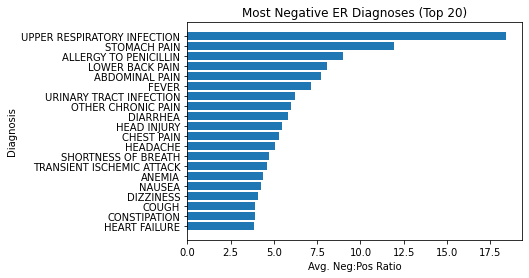

In [0]:
plt.barh(y = "ems_topic", width = "neg_pos", data = top_20_neg)
plt.title("Most Negative ER Diagnoses (Top 20)")
plt.ylabel('Diagnosis')
plt.xlabel('Avg. Neg:Pos Ratio')
plt.savefig(os.path.join(PLOT_DIR, "top_20_neg_diagnoses.jpg"))
plt.show()

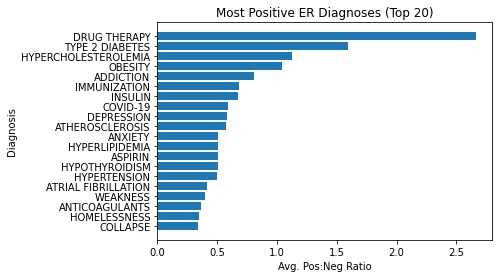

In [0]:
plt.barh(y = "ems_topic", width = "pos_neg", data = top_20_pos)
plt.title("Most Positive ER Diagnoses (Top 20)")
plt.ylabel('Diagnosis')
plt.xlabel('Avg. Pos:Neg Ratio')
plt.savefig(os.path.join(PLOT_DIR, "top_20_pos_diagnoses.jpg"))
plt.show()

In [0]:
## Save the csv's
top_20_neg.to_csv(os.path.join(CSV_DIR, "top_20_neg_diagnoses.csv"))
top_20_pos.to_csv(os.path.join(CSV_DIR, "top_20_pos_diagnoses.csv"))